# Clean up data

The data in this notebook comes from the flight computer of the Graupel-1 high altitude balloon, the source code of which is in this repository under the `tracker` directory.  It records telemetry from the GPS module and a pressure and temperature sensor twice a second to its SD card.

Let's take a look at what the data looks like.

In [1]:
import numpy as np
import pandas as pd

directory = '../data/'

# The flight tracker records invalid values as "*", so we want to replace those with Not a Number (NaN).
data = pd.read_csv(directory + '/raw-data.csv', na_values="*")
display(data.head())

,millis,year,month,day,hour,minute,second,voltage,satellites,hdop,gps_altitude_m,course,speed_mps,latitude,longitude,temperature_C,pressure_Pa,pressure_altitude_m,humidity_RH,Unnamed: 19
0,1146,2000,0,0,0,0,0,7.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.94,97332.17,337.86,23.20,NaN
1,1650,2000,0,0,0,0,0,7.16,0.0,99.99,NaN,NaN,NaN,NaN,NaN,30.00,97329.50,338.09,23.09,NaN
2,2151,2000,0,0,0,0,0,7.24,0.0,99.99,NaN,NaN,NaN,NaN,NaN,30.03,97332.11,337.87,23.05,NaN
3,2655,2000,0,0,0,0,0,7.24,0.0,99.99,NaN,NaN,NaN,NaN,NaN,30.02,97327.40,338.27,22.96,NaN
4,3160,2000,0,0,0,0,0,7.13,0.0,99.99,NaN,NaN,NaN,NaN,NaN,30.02,97331.42,337.93,21.75,NaN


The raw data is a bit noisy - especially the first dozen seconds or so before the GPS acquired its lock - so the first step is to clean up the invalid data and a few other transformations in order to make it easier to work with.

In [2]:
# The tracker stores each part of the timestamp in a different column. To make it easier for us to work with and
# graph, we convert those columns into a single timestamp column, and make it the index of the Pandas dataframe.
datetime_cols = ["year", "month", "day", "hour", "minute", "second"]
timestamps = data[datetime_cols].apply(lambda x: "{}-{}-{} {}:{}:{}".format(*x), axis=1)
data["timestamp"] = pd.to_datetime(timestamps, errors="coerce")
data = data.drop(datetime_cols, axis=1)

# The first few rows don't have a valid timestamp at all; we'll just get rid of them.
data = data[data["timestamp"].notnull()]
data.index = data["timestamp"]
data = data.drop(["timestamp"], axis=1)

# Fill any missing data with the last known value.  Then backfill missing data at the beginning of the file.
data = data.ffill().bfill()

# Removes the extraneous "unnamed" column.
data = data.dropna(how="all", axis=1)

data.head()

,millis,voltage,satellites,hdop,gps_altitude_m,course,speed_mps,latitude,longitude,temperature_C,pressure_Pa,pressure_altitude_m,humidity_RH
timestamp,,,,,,,,,,,,,
2021-06-19 17:24:53,10188,7.24,0.0,99.99,362.4,0.0,0.2,47.595039,-120.664879,30.06,97332.05,337.88,23.72
2021-06-19 17:24:53,10692,7.21,0.0,99.99,362.4,0.0,0.2,47.595039,-120.664879,30.05,97331.77,337.90,23.61
2021-06-19 17:24:54,11194,7.18,0.0,99.99,362.4,0.0,0.2,47.595039,-120.664879,30.05,97329.08,338.13,23.27
2021-06-19 17:24:54,11698,7.24,0.0,99.99,362.4,0.0,0.2,47.595039,-120.664879,30.07,97331.11,337.95,23.41
2021-06-19 17:24:55,12199,7.24,0.0,99.99,362.4,0.0,0.2,47.595039,-120.664879,30.06,97329.36,338.11,22.99


That's much better, but we turned the tracker on almost an hour before launch, and that data is kind of boring, so let us compute some interesting time spans and crop our data to just the mission data.

In [3]:
launch_index = np.argmax(data['gps_altitude_m'].diff() > 5) # TODO, index this off the GoPro data.
launch_millis = data['millis'][launch_index]
launch_time = data.index[launch_index]
data['mission_millis'] = data['millis'] - launch_millis

burst_altitude_index = np.argmax(data['gps_altitude_m'])
burst_time = data.index[burst_altitude_index]
landing_time = data.index[-1]

print("Launch Time (UTC) : {}".format(launch_time))
print("Burst Time        : {}".format(burst_time))
print("Landing Time      : {}".format(landing_time))

ascent_duration = burst_time - launch_time
descent_duration = landing_time - burst_time
mission_duration = ascent_duration + descent_duration

print("Mission Duration  : {}".format(mission_duration))
print("Ascent Duration   : {}".format(ascent_duration))
print("Descent Duration  : {}".format(descent_duration))

Launch Time (UTC) : 2021-06-19 18:24:54
Burst Time        : 2021-06-19 20:36:53
Landing Time      : 2021-06-19 20:59:40
Mission Duration  : 0 days 02:34:46
Ascent Duration   : 0 days 02:11:59
Descent Duration  : 0 days 00:22:47


In [4]:
mission_data = data[data['mission_millis'] >= 0]
mission_data.head()

,millis,voltage,satellites,hdop,gps_altitude_m,course,speed_mps,latitude,longitude,temperature_C,pressure_Pa,pressure_altitude_m,humidity_RH,mission_millis
timestamp,,,,,,,,,,,,,,
2021-06-19 18:24:54,3609244,7.16,9.0,1.11,364.5,234.9,2.2,47.595039,-120.664993,38.52,97109.09,357.07,14.15,0
2021-06-19 18:24:54,3609747,7.13,9.0,1.11,364.5,234.9,2.2,47.595039,-120.664993,38.27,97078.66,359.69,13.87,503
2021-06-19 18:24:55,3610248,7.16,9.0,1.11,369.7,243.3,1.8,47.595039,-120.665016,38.05,97052.55,361.94,13.44,1004
2021-06-19 18:24:55,3610750,7.13,9.0,1.11,369.7,243.3,1.8,47.595039,-120.665016,37.87,97012.64,365.38,13.43,1506
2021-06-19 18:24:56,3611255,7.16,9.0,1.10,374.7,147.8,6.5,47.595013,-120.664993,37.70,96976.97,368.46,12.86,2011


The very observant may notice a problem in the data above... It turns out, I made a bit of a mistake in the code.  I log the data twice a second although the GPS only updates once per second.  This results in the GPS data being duplicated, which makes analysis a little more difficult.

The easiest fix is to just remove every other row.

In [5]:
mission_data = mission_data.iloc[::2]
mission_data.head()

,millis,voltage,satellites,hdop,gps_altitude_m,course,speed_mps,latitude,longitude,temperature_C,pressure_Pa,pressure_altitude_m,humidity_RH,mission_millis
timestamp,,,,,,,,,,,,,,
2021-06-19 18:24:54,3609244,7.16,9.0,1.11,364.5,234.9,2.2,47.595039,-120.664993,38.52,97109.09,357.07,14.15,0
2021-06-19 18:24:55,3610248,7.16,9.0,1.11,369.7,243.3,1.8,47.595039,-120.665016,38.05,97052.55,361.94,13.44,1004
2021-06-19 18:24:56,3611255,7.16,9.0,1.10,374.7,147.8,6.5,47.595013,-120.664993,37.70,96976.97,368.46,12.86,2011
2021-06-19 18:24:57,3612258,7.18,9.0,1.11,380.7,137.5,5.6,47.594978,-120.664955,37.53,96916.61,373.67,13.01,3014
2021-06-19 18:24:58,3613261,7.16,9.0,1.11,387.0,140.8,4.9,47.594963,-120.664932,37.21,96851.35,379.30,13.69,4017


# Data analysis

Now that the data is cleaned up, we can start to take a look at it and see what we can learn.  In addition to pretty graphs, we are also interested in learning how we can improve the next flight.  The following questions are particularly pressing:

1. Why did the camera - a GoPro Hero Black 9 - stop recording approximately 54 minutes into the flight?
1. Why did the balloon travel so far east of its predicted course?
1. Why did the balloon descend so fast - did the parachute work as designed?

In [6]:
# We start by setting up and formatting our graphs.
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_style("ticks")

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['figure.dpi']= 150

# Show ticks every 15 minutes.
locator = mdates.MinuteLocator(byminute=[0,15,30,45])
formatter = mdates.ConciseDateFormatter(locator)

def pretty_plots(nrows=1, ncols=1):
    fig, ax = plt.subplots(nrows, ncols, tight_layout=True)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    return ax

## Altitude

The first obvious thing to do is to plot the altitude and see what we get. In our case, we have 2 sources of data for the altitude: the value reported by the GPS and a value derived from the barometric pressure sensor.  Let's see what we've got...

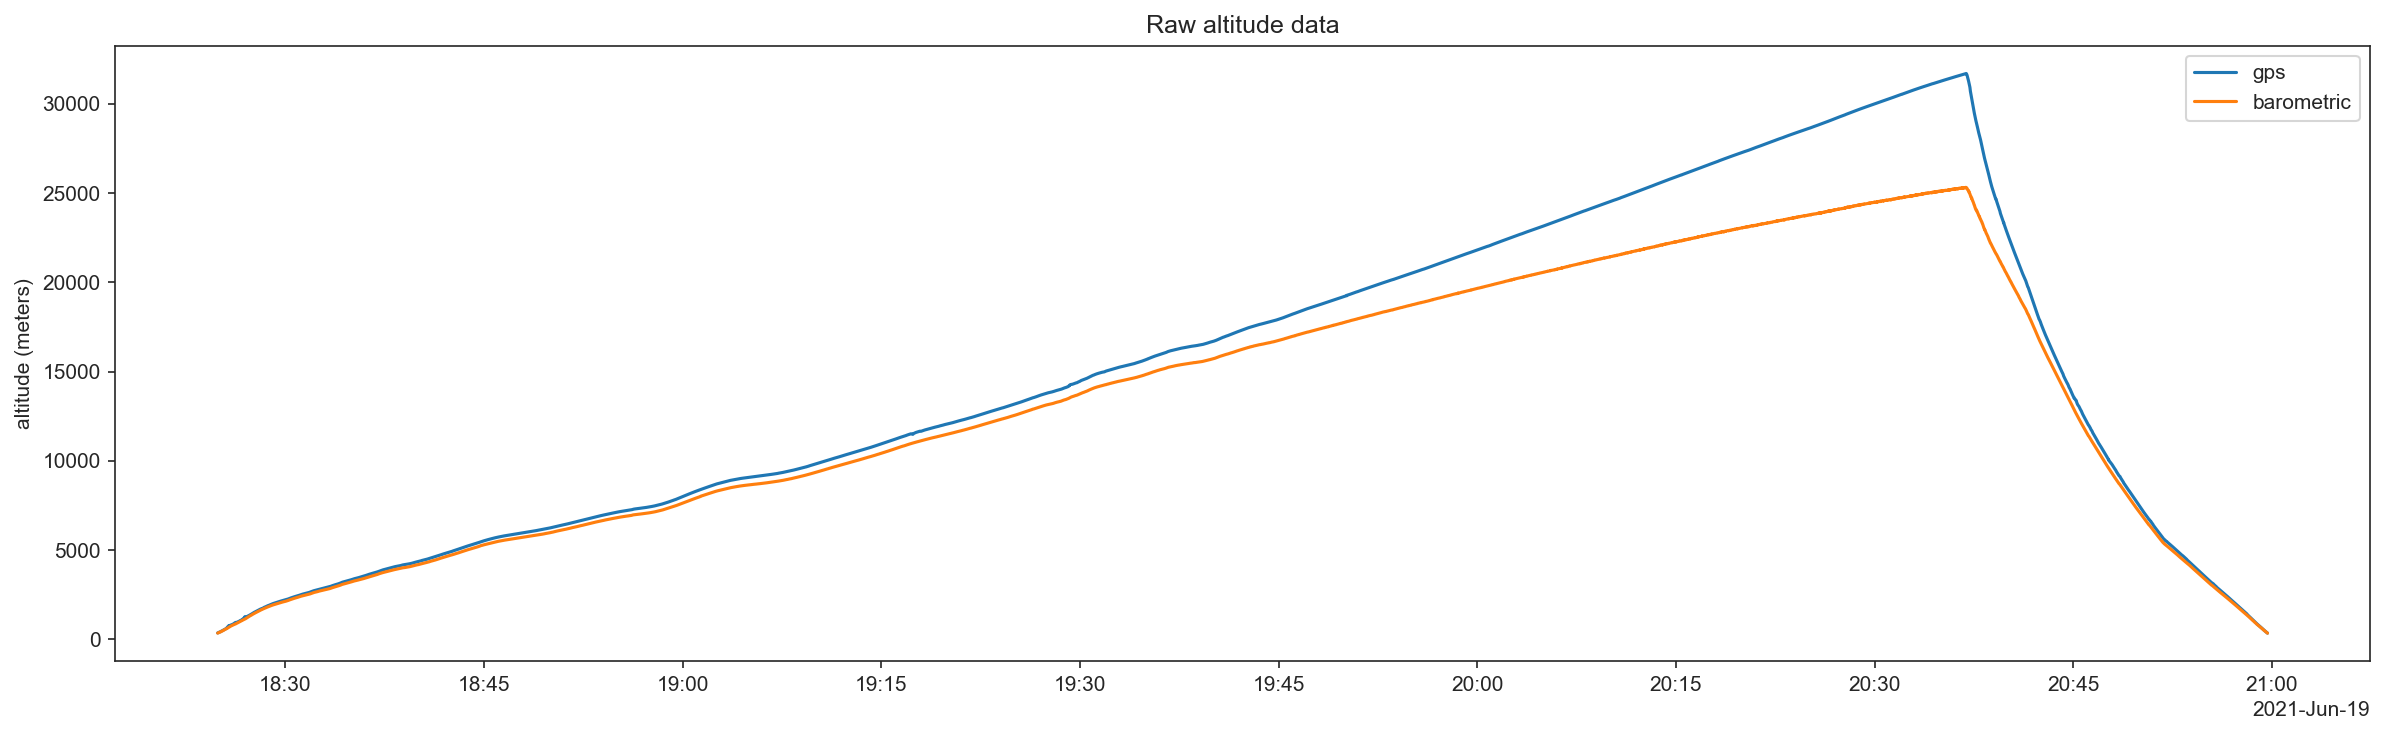

In [7]:
ax = pretty_plots()
ax.plot(mission_data[["gps_altitude_m", "pressure_altitude_m"]])
ax.set_ylabel("altitude (meters)")
ax.legend(["gps", "barometric"])
ax.set_title('Raw altitude data')
plt.show()

Hmm... already we see something is up. The altitude from our barometer starts to drift from the altitude from the GPS?  What's going on here?

We compute the altitude from the barometric pressure in the `Sensors.cpp` as follows:

```
// Equation taken from BMP180 datasheet (page 16):
//  http://www.adafruit.com/datasheets/BST-BMP180-DS000-09.pdf

// Note that using the equation from wikipedia can give bad results
// at high altitude. See this thread for more information:
// http://forums.adafruit.com/viewtopic.php?f=22&t=58064
return 44330.0 * (1.0 - pow(atmosphericPressurePa / seaLevelPressurePa, 0.1903));
```

Of note is that we assume an air pressure at MSL of 101325 Pa which is the [Standard Pressure](https://en.wikipedia.org/wiki/Standard_atmosphere_(unit)) but the pressure of the air column depends on many factors, so this is just an estimate.

Now, if we read the forum post there, we get a clue at the problem. The forumula we're using makes assumptions that are only valid in the lowest layer of Earth's atmosphere - the troposphere.  Above that, in the stratosphere, there are different rules in play, so we need a different formula!

Okay... so when did we enter the stratosphere? According to [Wikipedia](https://en.wikipedia.org/wiki/Atmosphere_of_Earth) the troposphere extends to an altitude between 9 and 17 km, depending on conditions. How can we tell where the stratosphere begins on the day of our mission?

We can look at the temperature!

## Adjusting for the stratosphere

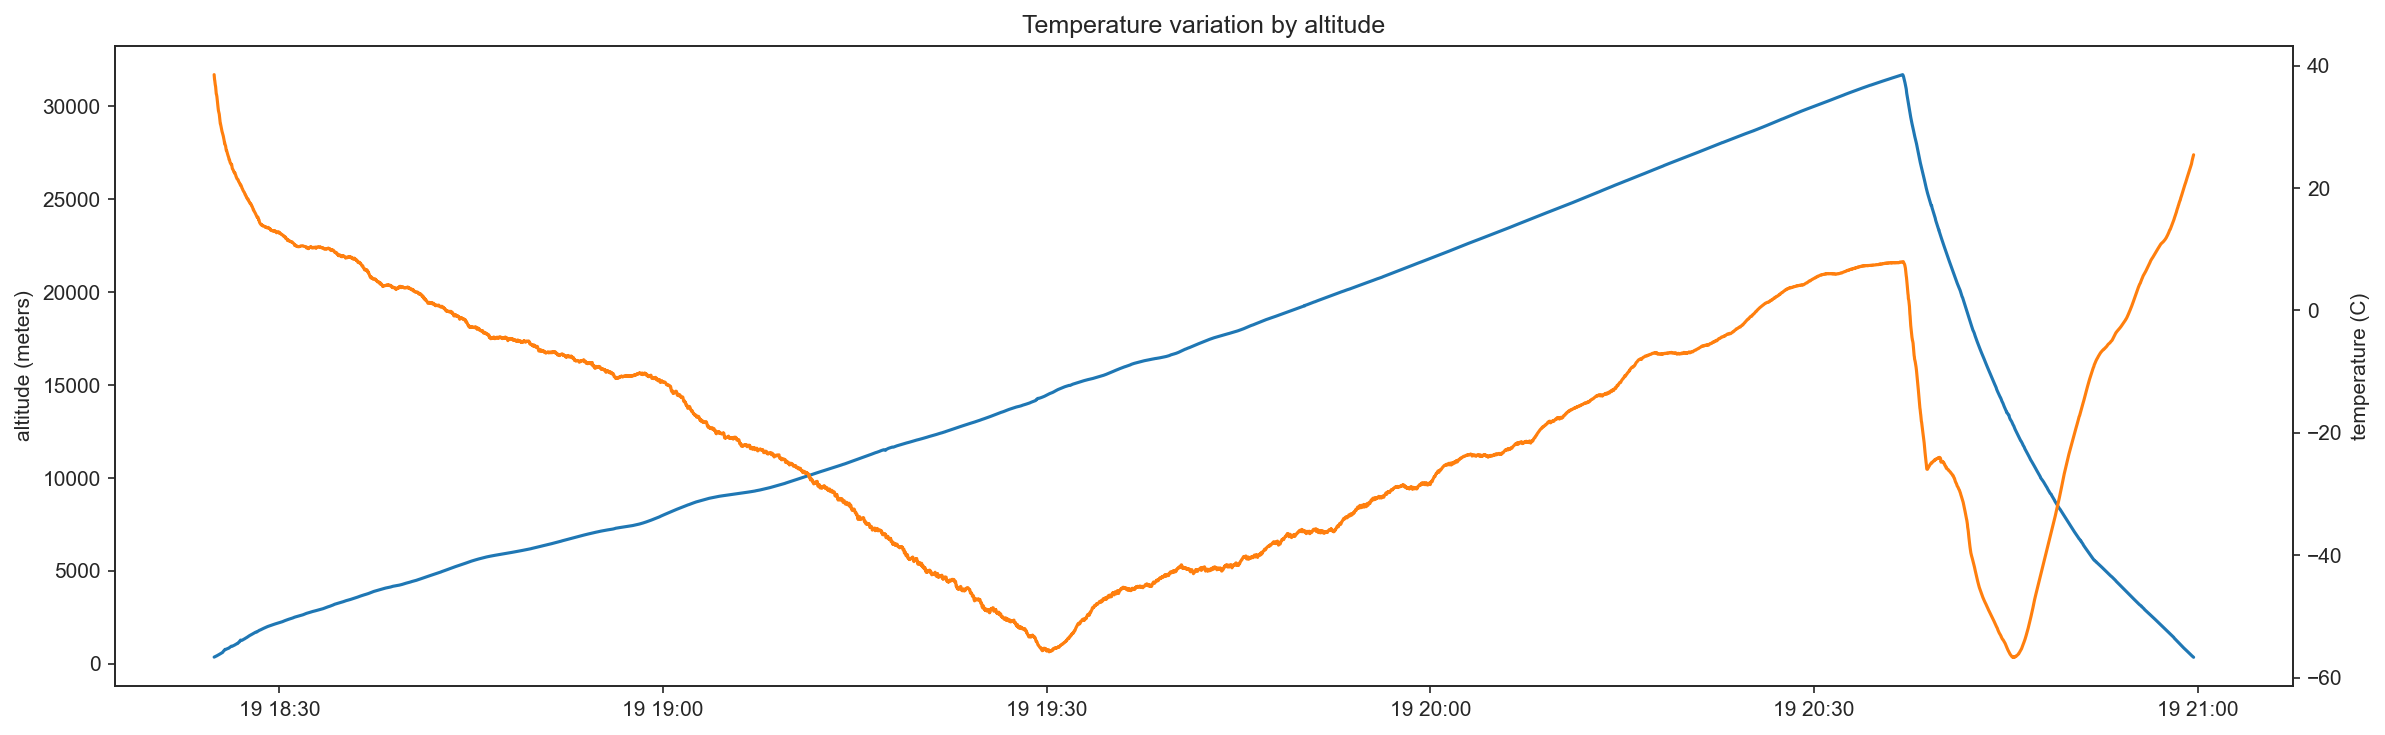

In [8]:
# Plot the altitude and temperature together.
ax = pretty_plots()
ax.set_title("Temperature variation by altitude")

ax.plot(mission_data["gps_altitude_m"])
ax.set_ylabel("altitude (meters)")

ax2 = ax.twinx()
ax2.plot(mission_data["temperature_C"], color="C1")
ax2.set_ylabel("temperature (C)")

plt.show()

As anyone who has looked at a snow-capped peak knows, the temperature decreases as altitude increases. However, something interesting happens at the tropopause - the boundary between the troposphere and the stratosphere. The temperature starts to rise again, caused by the ozone layer absorbing UV radiation from the sun.

We can find that boundary by looking by looking at the minimum temperature our tracker recorded.  This will also be useful later on as we look at other data, so we'll keep it in mind.

In [9]:
min_temperature_C = mission_data['temperature_C'].min()
min_temperature_index = np.argmin(mission_data['temperature_C'])

tropopause_temperature_K = min_temperature_C + 273.15
tropopause_pressure_Pa = mission_data['pressure_Pa'][min_temperature_index]
tropopause_altitude_m = mission_data['gps_altitude_m'][min_temperature_index]

print("Temperature at tropopause : {0:0.1f} ℃".format(min_temperature_C))
print("Pressure at tropopause    : {0:0.1f} Pa".format(tropopause_pressure_Pa))
print("Altitude of tropopause    : {0:0.1f} m".format(tropopause_altitude_m))

Temperature at tropopause : -56.6 ℃
Pressure at tropopause    : 18685.8 Pa
Altitude of tropopause    : 12862.0 m


Cool, we were able to measure the location of the tropopause!

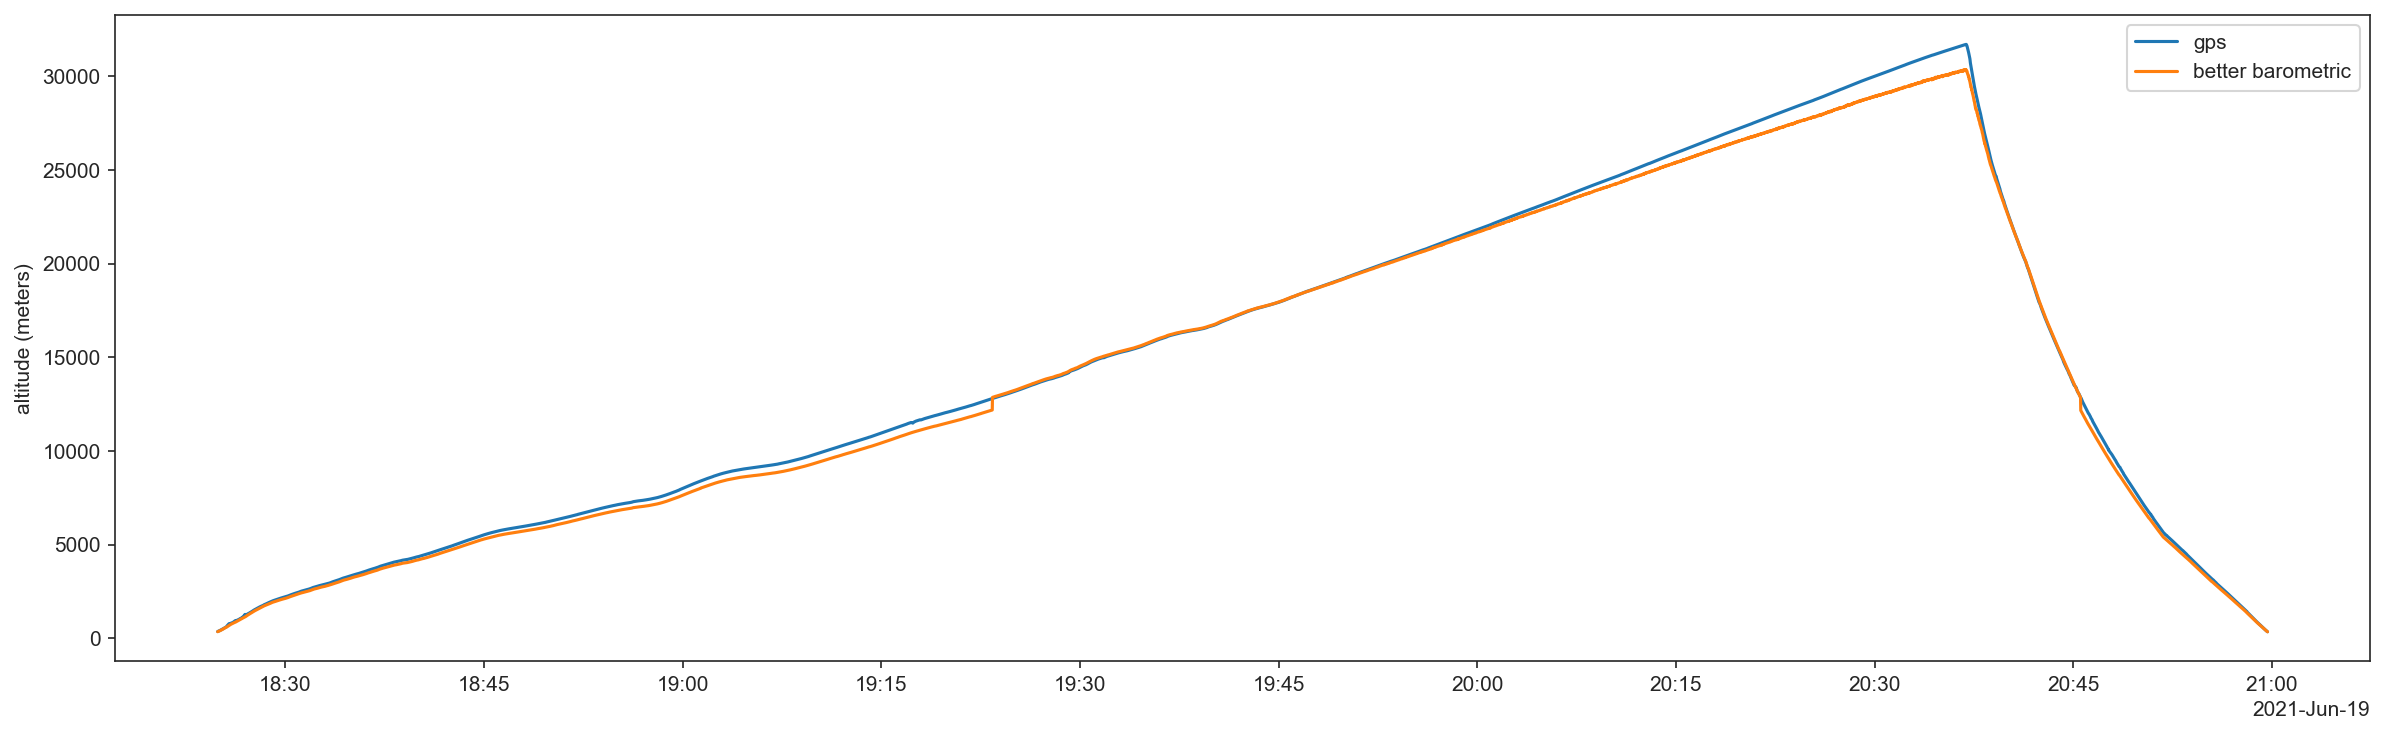

In [10]:
# Various constants used below, based on standard atmospheric assumptions.

standard_atmosphere_Pa = 101325
standard_temperature_K = 288.15 
temperature_lapse_rate = -0.0065 # K/m

universal_gas_constant = 8.31432 # N*m/mol*K
molar_mass = 0.0289644 # kg/mol
gravitational_acceleration = -9.80665 # m/s^2
g0_m = gravitational_acceleration * molar_mass

troposphere_factor = standard_temperature_K / temperature_lapse_rate
troposphere_exponent = (universal_gas_constant * temperature_lapse_rate) / g0_m
stratosphere_factor = (universal_gas_constant * tropopause_temperature_K) / g0_m

def altitude_from_pressure_refined(pressure_Pa):
    """
    Calculates the altitude (in meters) for a given barometric pressure, valid for the troposphere
    and stratosphere.
    
    Calculations from: https://www.mide.com/air-pressure-at-altitude-calculator
    """
    
    if(pressure_Pa > tropopause_pressure_Pa):
        return troposphere_factor * (pow(pressure_Pa / standard_atmosphere_Pa, troposphere_exponent) - 1.0)
    else:
        return tropopause_altitude_m + stratosphere_factor * np.log(pressure_Pa / tropopause_pressure_Pa)
    
mission_data['better_pressure_altitude_m'] = mission_data['pressure_Pa'].apply(altitude_from_pressure_refined)
ax = pretty_plots()
ax.plot(mission_data[['gps_altitude_m', 'better_pressure_altitude_m']])
ax.set_ylabel("altitude (meters)")
ax.legend(["gps", "better barometric"])
plt.show()

Okay, that's better but not perfect. The difference is probably due to the choice of constants above, which are based on standard atmospheric conditions, but may be different on the day and location of our launch. I may go back and revisit this at a later date to see if I can improve upon it further.

A reasonable question may be: Why bother having two sources of altitude at all? Well, other than because I could, I was primarily thinking to use the barometric pressure as a back up in case the GPS went out. Turns out, that wasn't a worry - we maintained a strong signal lock throughout the entire journey.

The other reason is that I had noticed during testing that our GPS readings were accurate but often imprecise. Even sitting still, the GPS will report altitude differences in dozens of meters. The barometer, however, was generally very precise.  Together, the two sources of altitude could be used to create a more accurate reading.

Let's see if that holds on this flight...

## You have your unknown unknowns

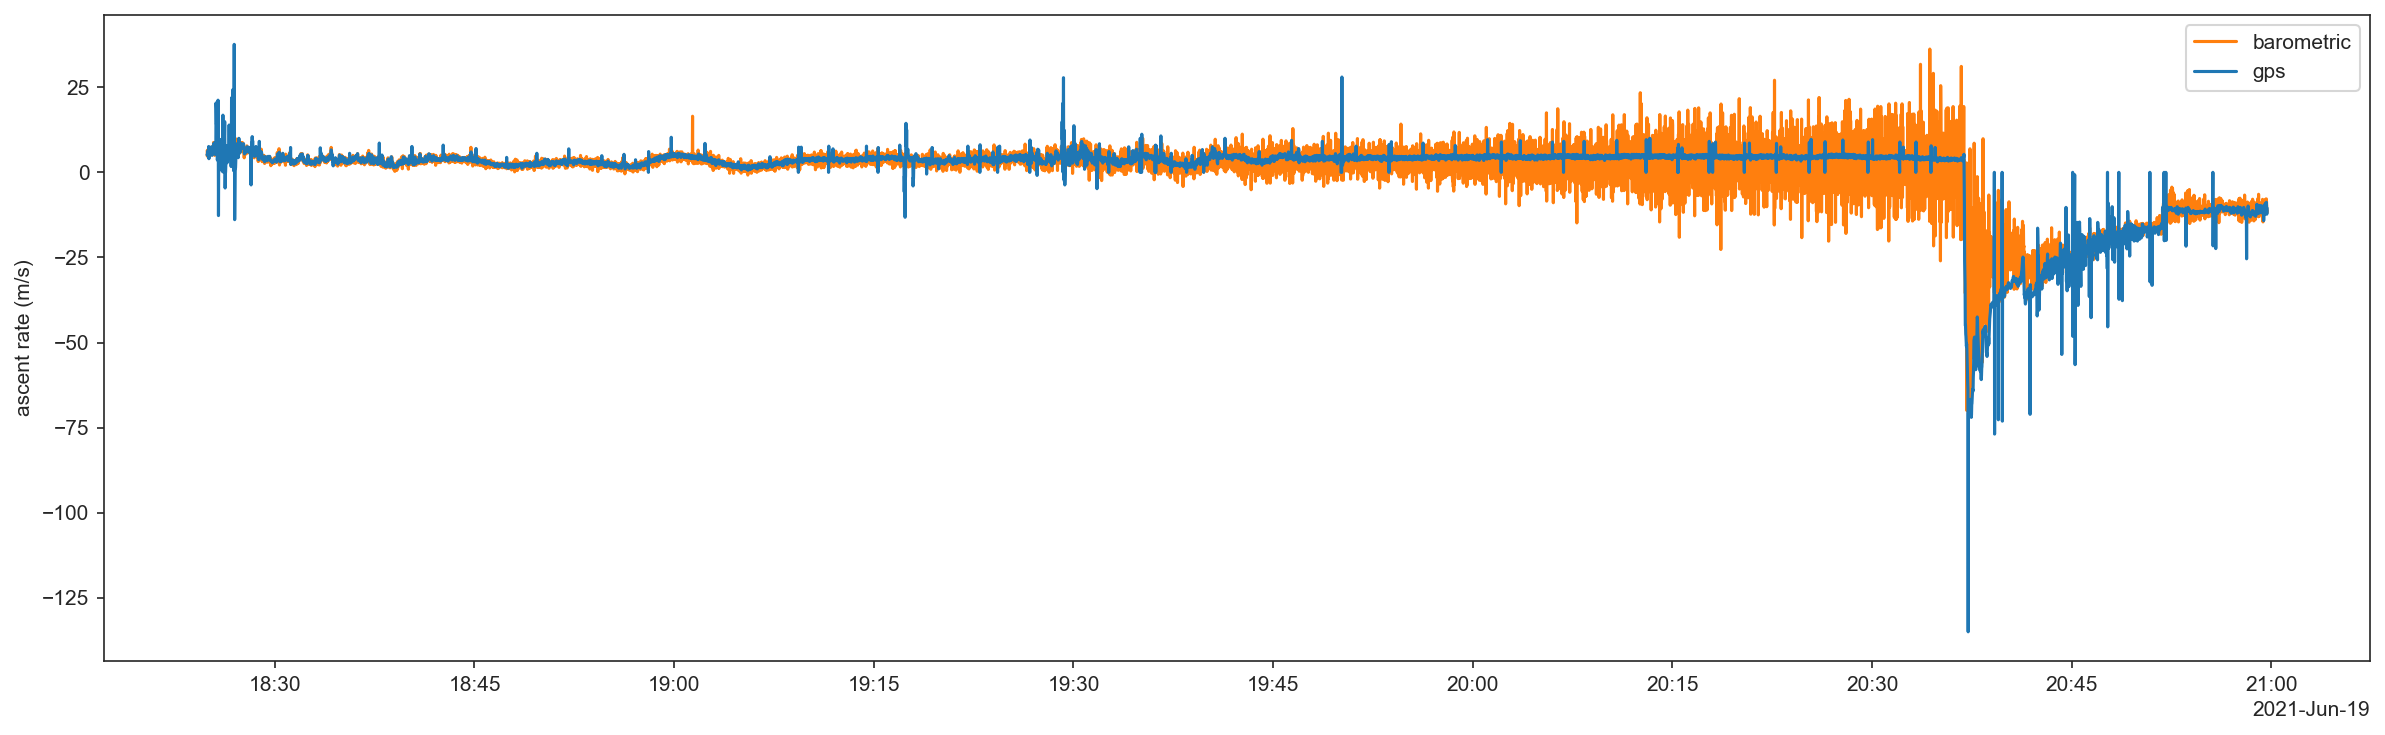

In [11]:
gps_ascent_rate = mission_data['gps_altitude_m'].diff()
pressure_ascent_rate = mission_data['pressure_altitude_m'].diff()

ax = pretty_plots()
ax.plot(pressure_ascent_rate, color="C1")
ax.plot(gps_ascent_rate, color="C0")
ax.legend(["barometric", "gps"])
ax.set_ylabel("ascent rate (m/s)")
plt.show()

Alright, what the heck! Other than some obvious outliers and some noise early in the ascent phase, it seems that the GPS altitude is much more precise over this run, especially as we get into the stratosphere.

Let's take a look at the underlying data: the barometric pressure. Maybe our barometer doesn't work so well at low pressure.

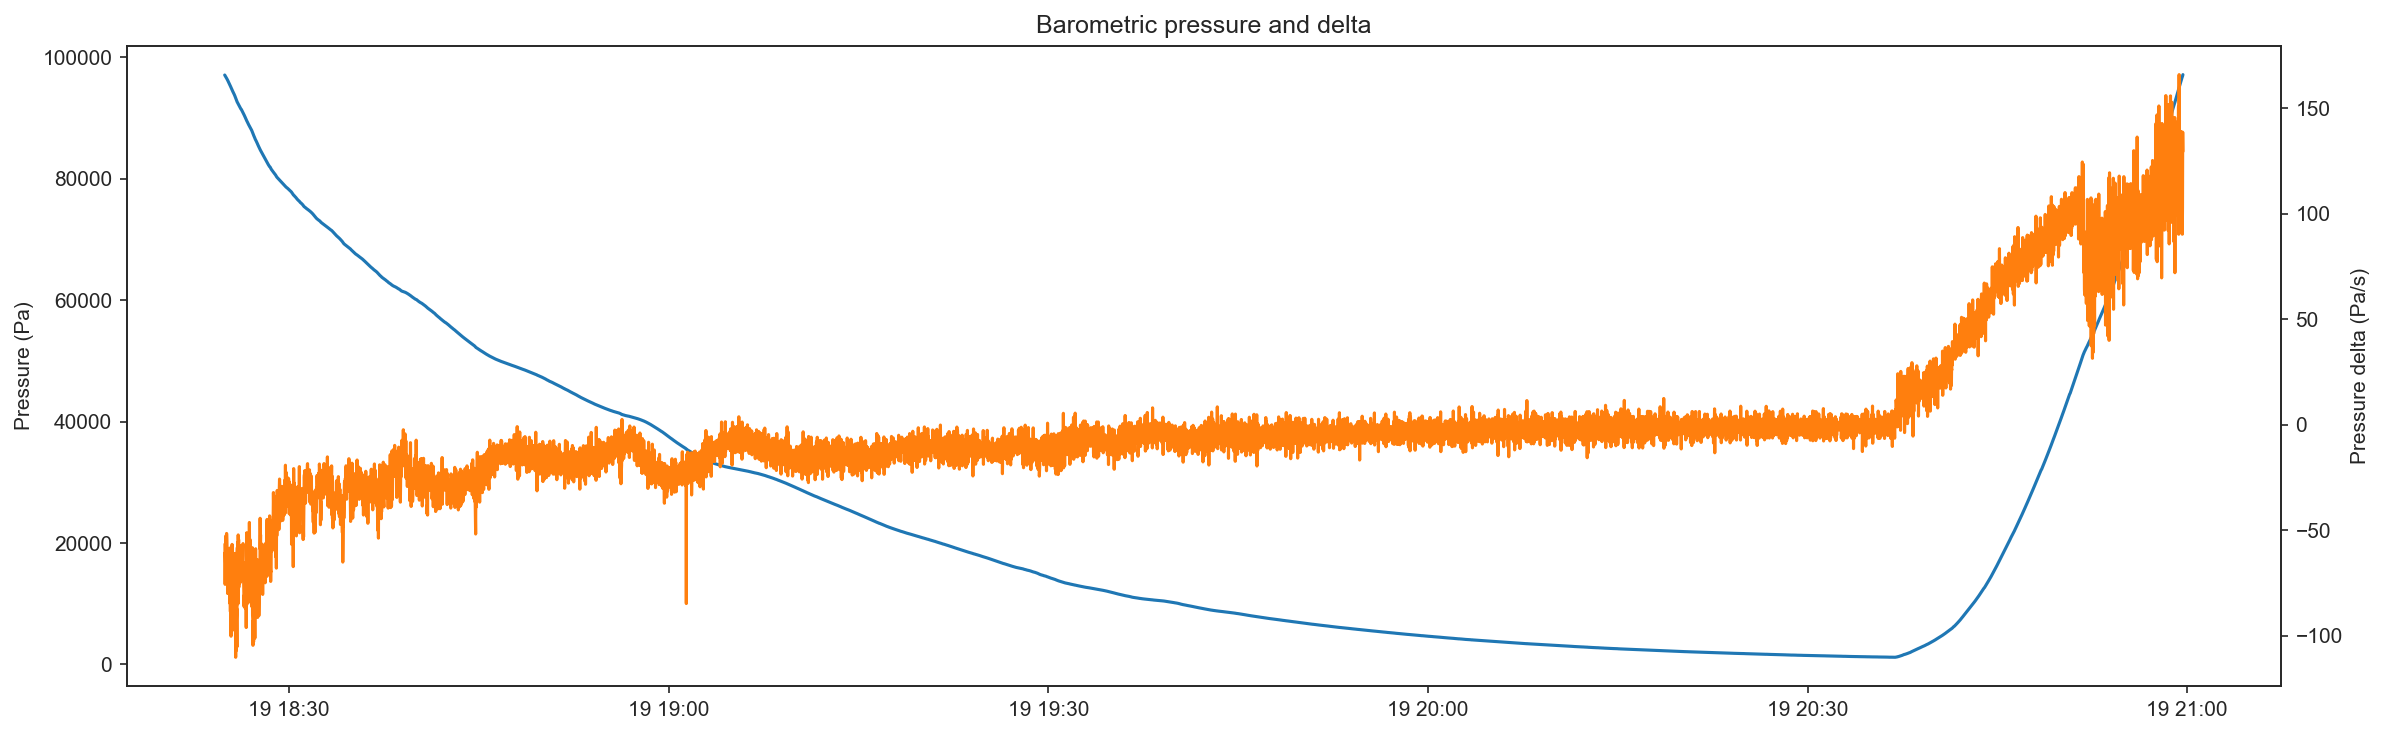

In [12]:
ax = pretty_plots()
ax.plot(mission_data['pressure_Pa'])
ax.set_ylabel("Pressure (Pa)")

ax2 = ax.twinx()
ax2.plot(mission_data['pressure_Pa'].diff(), color="C1")
ax2.set_ylabel("Pressure delta (Pa/s)")

ax.set_title("Barometric pressure and delta")
plt.show()

This seems reasonable enough, apart from noise as our balloon was plummeting through the troposphere. So what's going on?

After some thought, it occured to me that the formula from pressure to altitude is logarithmic! So, a small error in pressure will translate to a larger error as pressure decreases. And this is exactly what we're seeing above.

## Smoothing the altitude

Now, in order to smooth the noise in our altitude reading, I am going to apply an exponential weighted average (EWM) and then combine both the GPS and pressure readings together to get a blend.

The first step is to find an alpha parameter for our EWM that looks suitable. The alpha parameter describes how much weight to apply to the most recent data point compared to the previous data points. An alpha of 1.0 applies no smoothing.

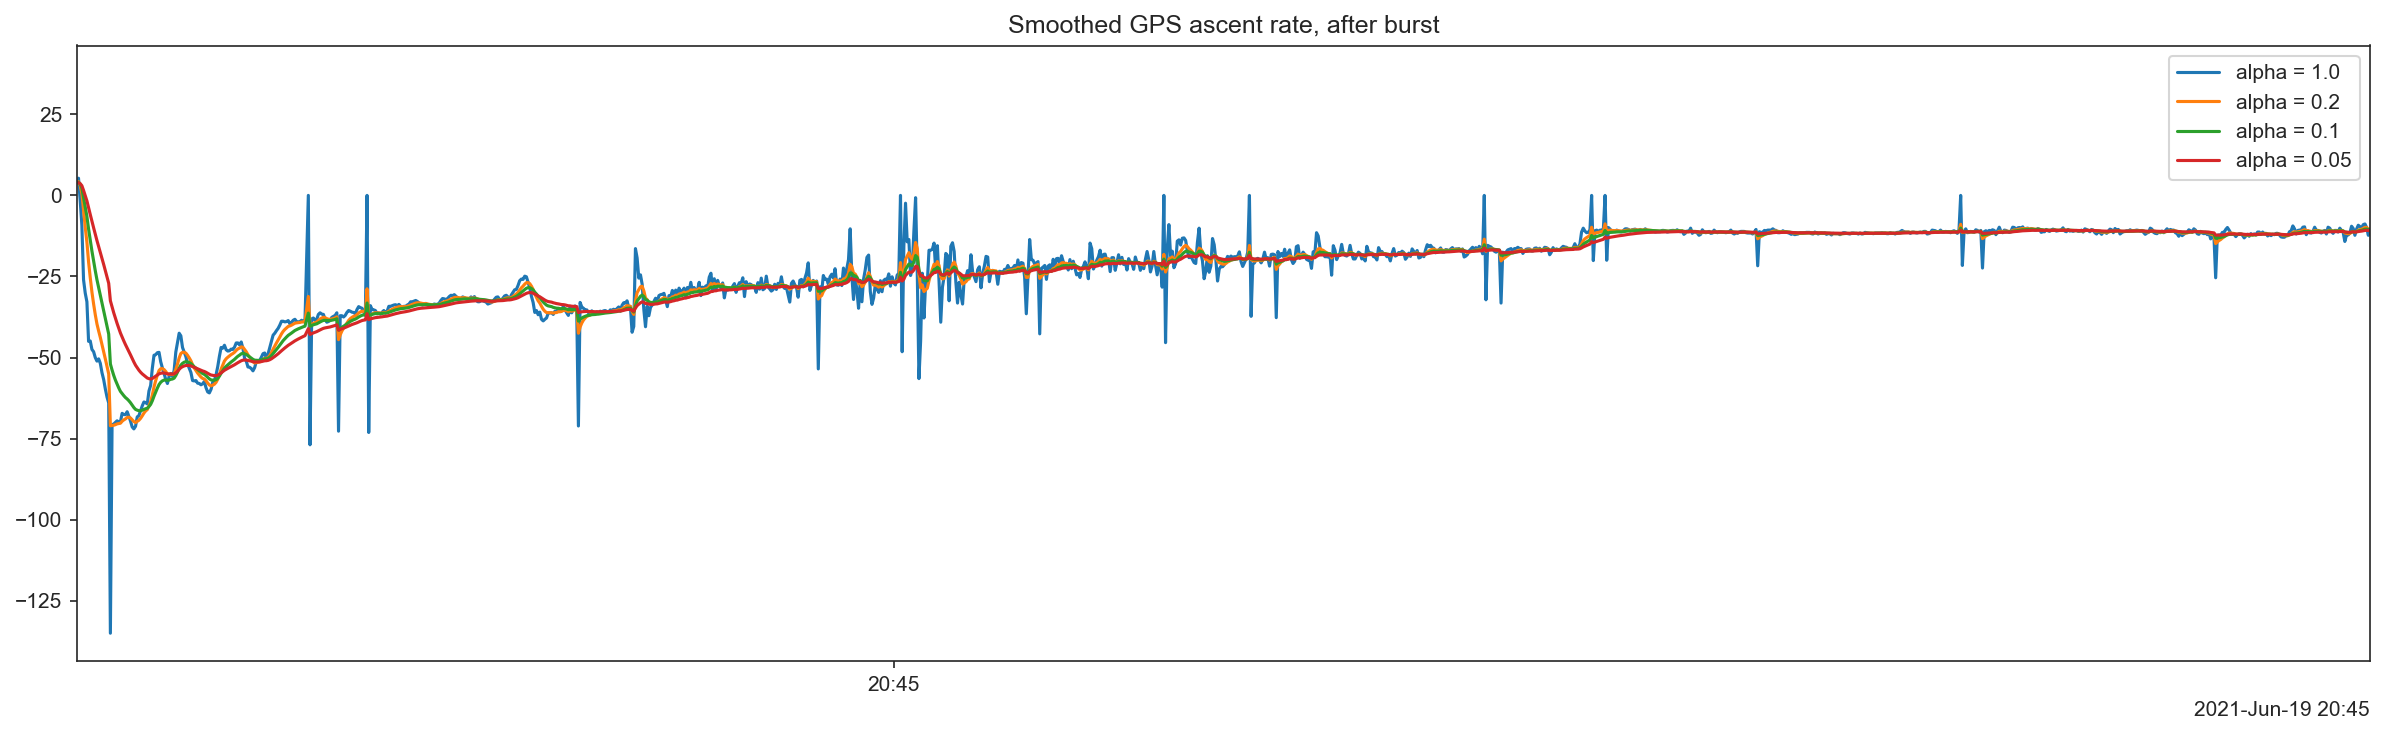

In [13]:
ax = pretty_plots()
ax.set_xlim(burst_time, landing_time)

for alpha in [1.0, 0.2, 0.1, 0.05]:
    smoothed_gps_data = mission_data['gps_altitude_m'].ewm(alpha=alpha).mean()
    ax.plot(smoothed_gps_data.diff(), label="alpha = {}".format(alpha))

ax.set_title("Smoothed GPS ascent rate, after burst")
ax.legend()
plt.show()

For the GPS altitude, with its spurious outliers, applying an aggressive smoothing looks good, but anything much higher than 0.2 loses the detail during the sudden deceleration phase of the descent (when the balloon pops and starts rocketing through the stratosphere).

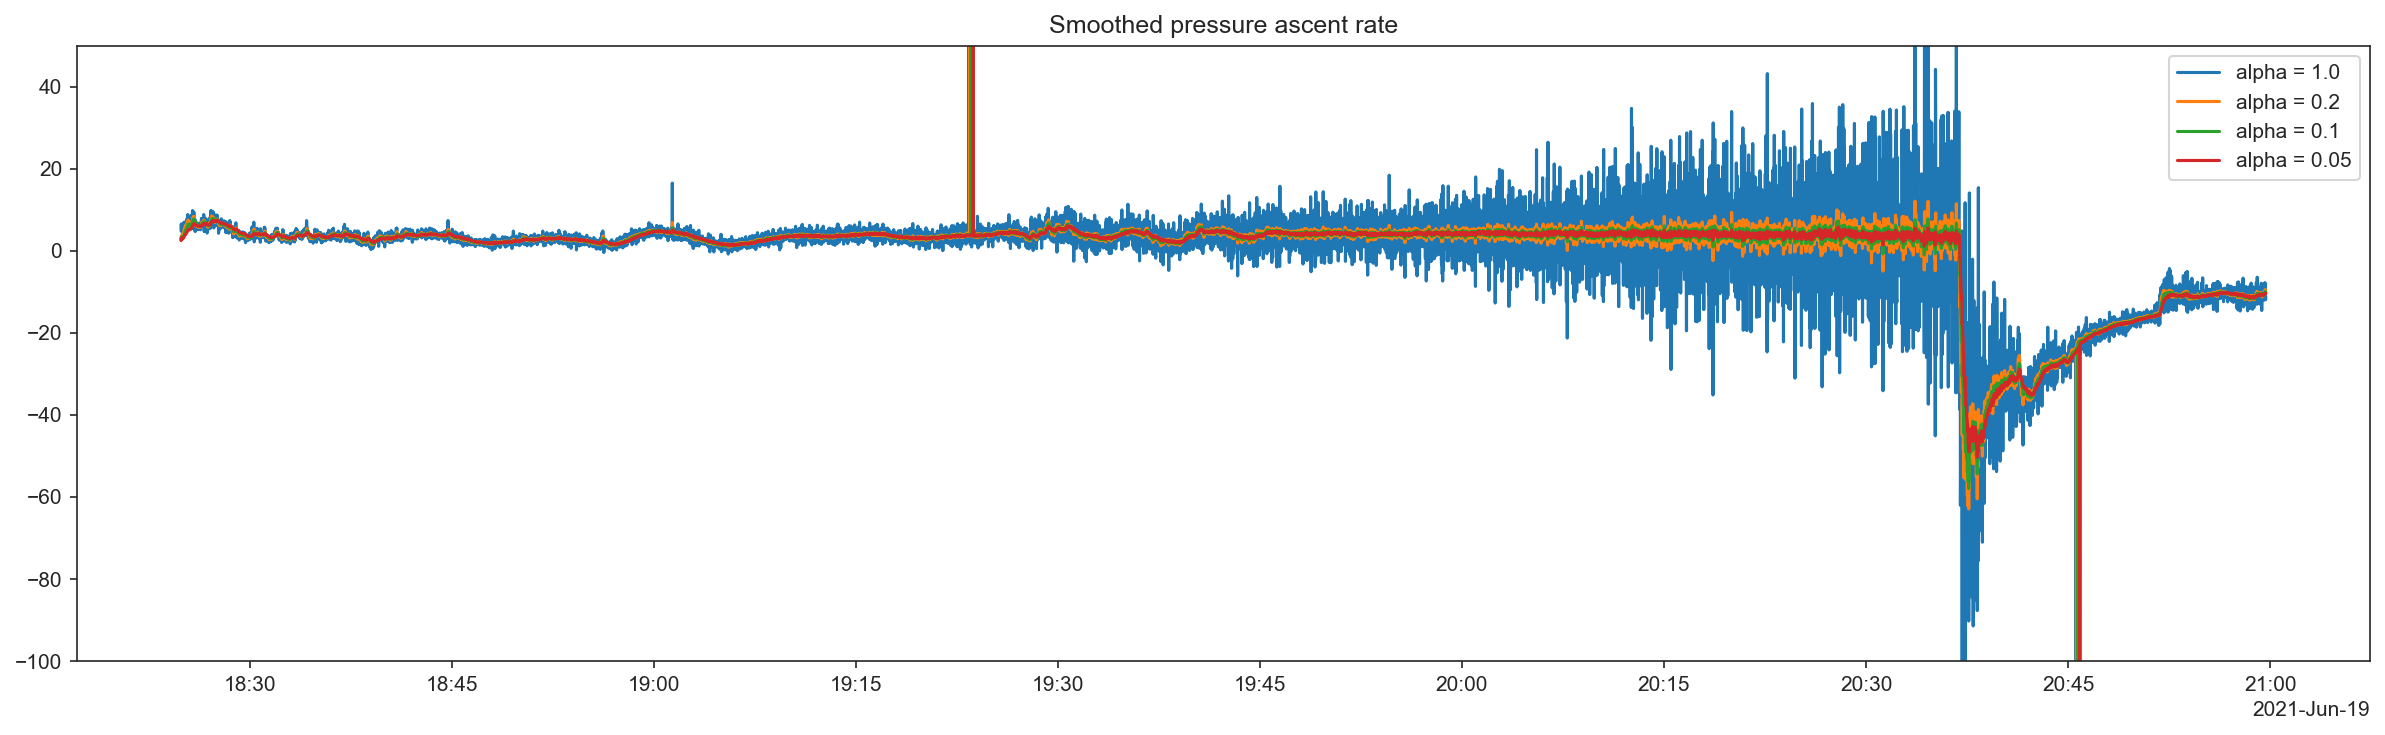

In [14]:
ax = pretty_plots()
ax.set_ylim(-100, 50)

for alpha in [1.0, 0.2, 0.1, 0.05]:
    smoothed_pressure = mission_data['pressure_Pa'].ewm(alpha=alpha).mean()
    smoothed_pressure_altitude = smoothed_pressure.apply(altitude_from_pressure_refined)
    ax.plot(smoothed_pressure_altitude.diff(), label="alpha = {}".format(alpha))
    
ax.set_title("Smoothed pressure ascent rate")
ax.legend()
plt.show()

The noise in the barometric pressure appears much more normally distributed than the GPS (which, as an analog vs digtal device, makes sense), so smoothing seems to work incredibly well here.  Even aggressive values of alpha seem to track the trend very well, with a notable exception of the balloon burst.  I'll choose an alpha of 0.1 here.

Finally, until I fix the calculation for altitude from pressure, I'm going to use the smoothed GPS altitude going forward.

In [15]:
mission_data['smoothed_gps_altitude_m'] = mission_data['gps_altitude_m'].ewm(alpha=0.2).mean()
mission_data['smoothed_pressure_Pa'] = mission_data['pressure_Pa'].ewm(alpha=0.1).mean()
mission_data['smoothed_pressure_altitude_m'] = mission_data['smoothed_pressure_Pa'].apply(altitude_from_pressure_refined)

weight = 0.9
#mission_data['altitude_m'] = \
#    (mission_data['smoothed_gps_altitude_m'] * weight) + \
#    (mission_data['smoothed_pressure_altitude_m'] * (1-weight))
mission_data['altitude_m'] = mission_data['smoothed_gps_altitude_m']

## Altitude statistics

Finally, we can now compute some interesting altitude statistics and use them to answer some questions about our mission.

In [16]:
burst_altitude_index = np.argmax(mission_data['altitude_m'])
burst_altitude_m = mission_data['altitude_m'].max()
burst_altitude_ft = burst_altitude_m / 0.305

print("Burst altitude: {0:0.1f} meters ({1:0.1f} feet)".format(burst_altitude_m, burst_altitude_ft))

Burst altitude: 31694.5 meters (103916.2 feet)


In [17]:
mission_data['ascent_rate_mps'] = mission_data['altitude_m'].diff()
ascent_phase = mission_data[mission_data.index < burst_time]
descent_phase = mission_data[mission_data.index > burst_time]

print("Maximum ascent rate: {0:0.2f} m/s".format(ascent_phase['ascent_rate_mps'].max()))
print("Average ascent rate: {0:0.2f} m/s".format(ascent_phase['ascent_rate_mps'].mean()))
print()
print("Maximum descent rate: {0:0.2f} m/s".format(descent_phase['ascent_rate_mps'].min()*-1))
print("Average descent rate: {0:0.2f} m/s".format(descent_phase['ascent_rate_mps'].mean()*-1))

Maximum ascent rate: 16.92 m/s
Average ascent rate: 3.98 m/s

Maximum descent rate: 71.03 m/s
Average descent rate: 23.04 m/s


## Effectiveness of parachute

In [18]:
close_to_ground = descent_phase[descent_phase['altitude_m'] < 5000]
descent_rate_close_to_ground = close_to_ground['ascent_rate_mps'].mean() * -1

print("Average descent while under 5000 m: {0:0.2f} m/s".format(descent_rate_close_to_ground))

Average descent while under 5000 m: 11.36 m/s


/Volumes/workplace/personal/graupel-1/processing/.venv/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Volumes/workplace/personal/graupel-1/processing/.venv/lib/python3.7/site-packages/pyproj/crs/crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


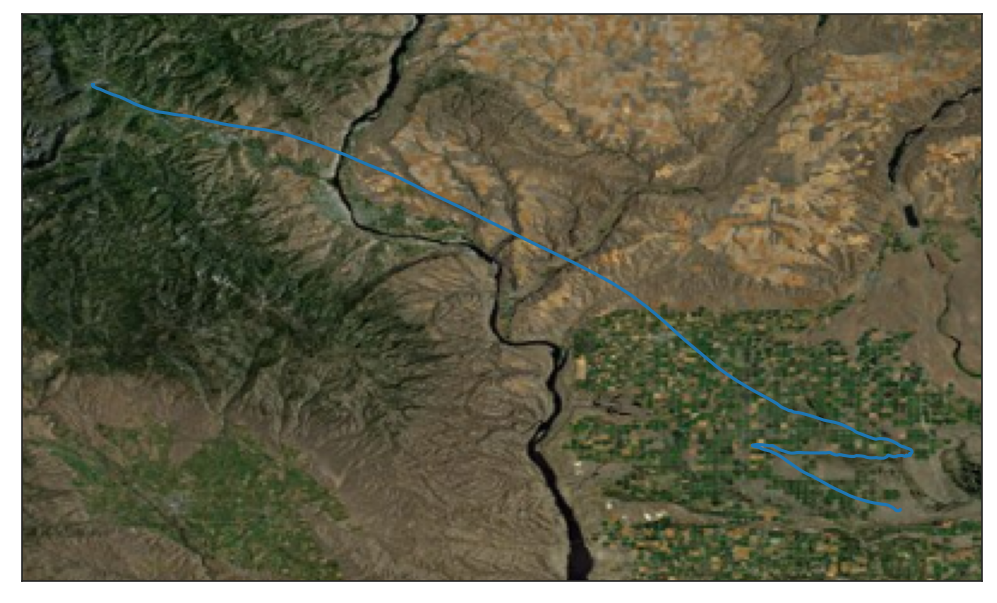

In [19]:
from mpl_toolkits.basemap import Basemap

avg_lat = data['latitude'].mean()
avg_lon = data['longitude'].mean()

fig,ax = plt.subplots()

#map = Basemap(projection='lcc', resolution='i',
#      width=2e5, height=2e5,
#      lat_0=avg_lat, lon_0=avg_lon,)
#map.shadedrelief()

padding = 0.1

# projection='cass', resolution='i', 
map = Basemap(epsg=4326,
    lat_0 = data['latitude'].mean(),
    llcrnrlat=data['latitude'].min() - padding,
    urcrnrlat=data['latitude'].max() + padding,
    llcrnrlon=data['longitude'].min() - padding,
    urcrnrlon=data['longitude'].max() + padding,
    lon_0 = data['longitude'].mean())

#map = Basemap(llcrnrlon=-10.5,llcrnrlat=33,urcrnrlon=10.,urcrnrlat=46.,
#             resolution='i', projection='cass', lat_0 = 39.5, lon_0 = 0.)

map.arcgisimage(service='ESRI_Imagery_World_2D')

ax.plot(data['longitude'], data['latitude'])
